In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ML-Climate-Predicting-Wildfires/src')

Mounted at /content/drive


In [ ]:
!pip install keras-tuner -q
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D,\
                         TimeDistributed, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC

import keras_tuner as kt
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
import seaborn as sns

     |████████████████████████████████| 133 kB 29.7 MB/s 


In [ ]:
def process_channel_hist(X, n_channels=12, n_frames=6):
  histograms_batch = []
  for i_sample in range(X.shape[0]):
    histograms_sample = []
    for channel in range(n_channels):
      histograms_frame = []
      for frame in range(n_frames):
        histogram, _ = np.histogram( X[i_sample,frame,:,:,channel], bins=32)
        histograms_frame.append([histogram])
      histograms_frame = np.concatenate(histograms_frame, axis=0).T
      histograms_sample.append([histograms_frame])
    histograms_sample = np.concatenate(histograms_sample, axis=0).T
    histograms_batch.append([histograms_sample])
  histograms_batch = np.concatenate(histograms_batch, axis=0)
  histograms_batch = np.expand_dims(histograms_batch, axis=-1)
  return histograms_batch

class Batch_Loader(tf.keras.utils.Sequence) :
  
  def __init__(self, dataset_name) :
    self.dataset_name = dataset_name
    num_batches = len([x for x in os.listdir(f'data/TrainingData/{self.dataset_name}') if '_X.npy' in x])
    self.num_batches = num_batches
    
  def __len__(self) :
    return self.num_batches

  def __getitem__(self, idx) :
    X = np.load(f'data/TrainingData/{self.dataset_name}/{idx}_X.npy')
    X_hist = process_channel_hist(X)
    y = np.load(f'data/TrainingData/{self.dataset_name}/{idx}_y.npy')
    return X_hist, y

In [ ]:
train_generator = Batch_Loader('train')
val_generator = Batch_Loader('val')
test_generator = Batch_Loader('test')

In [ ]:
NBFRAME = 6
INPUT_WIDTH = 128
INPUT_HEIGHT = 128
N_CHANNELS = 12

def get_convnet(shape, hp):
    bn_momentum = hp.Float("bn_momentum", 0.9, 0.99, step=0.03)
    n_conv = hp.Int("n_fc", 1, 3, step=1)
    dim_conv = hp.Choice("dim_fc", values=[32,64,128])

    convnet = keras.Sequential()
    for i_conv in range(n_conv):
      convnet.add(Conv2D(dim_conv*2**i_conv, (3,3), input_shape=shape[1:],
          padding='same', activation='relu'))
      convnet.add(Conv2D(dim_conv*2**i_conv, (3,3), padding='same', activation='relu'))
      convnet.add(BatchNormalization(momentum=bn_momentum))
      convnet.add(MaxPool2D())
    convnet.add(Conv2D(dim_conv*2**n_conv, (3,3), padding='same', activation='relu'))
    convnet.add(Conv2D(dim_conv*2**n_conv, (3,3), padding='same', activation='relu'))
    convnet.add(BatchNormalization(momentum=bn_momentum))
    convnet.add(GlobalMaxPool2D())

    return convnet

def histogram_cnn_lstm(hp):
    shape=(NBFRAME,) + (32,) + (N_CHANNELS, 1) # (6, 32, 12, 1)
    dim_lstm = hp.Choice("dim_lstm", values=[32,64])
    droupout_rate = hp.Float("dropout", 0, 0.3, step=0.1)
    n_fc = hp.Int("n_fc", 1, 3, step=1)
    dim_fc = hp.Choice("dim_fc", values=[64,128])
    dim_fc_collapse = hp.Boolean("dim_fc_collapse")
    lr = hp.Float("lr", 1e-5, 1e-4, step=1e-5)
    eps = hp.Float("eps", 1e-8, 5e-8, step=1e-8)

    convnet = get_convnet(shape, hp)

    model = keras.Sequential()
    model.add(TimeDistributed(convnet,input_shape=shape))
    model.add(LSTM(dim_lstm))
    model.add(Dropout(droupout_rate))

    for i_fc in range(n_fc):
      collapse_factor = 2**i_fc if dim_fc_collapse else 1
      model.add(Dense(dim_fc/collapse_factor, activation='relu'))
      model.add(Dropout(droupout_rate))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = keras.optimizers.Adam(learning_rate=lr,
                                      epsilon=eps)
    model.compile(
        optimizer,
        'binary_crossentropy',
        metrics=['accuracy', Precision(), Recall(), AUC()])
    
    return model

#### Tuning hyperparameters

In [ ]:
# Instantiate the tuner
tuner = kt.RandomSearch(histogram_cnn_lstm,
                     objective=kt.Objective("val_auc", direction="max"),
                     max_trials=10,
                     executions_per_trial=1,
                     overwrite=False,
                     directory="models/Histogram_CNN_LSTM/",
                     project_name="HP_Tuning")

INFO:tensorflow:Reloading Oracle from existing project models/Histogram_CNN_LSTM/HP_Tuning/oracle.json
INFO:tensorflow:Reloading Tuner from models/Histogram_CNN_LSTM/HP_Tuning/tuner0.json


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
dim_lstm (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
n_fc (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
dim_fc (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
dim_fc_collapse (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.0001, 'step': 1e-05, 'sampling': None}
eps (Float)
{'default': 1e-08, 'conditions': [], 'min_value': 1e-08, 'max_value': 5e-08, 'step': 1e-08, 'sampling': None}
bn_momentum (Float)
{'default': 0.9, 'conditions': [], 'min_value': 0.9, 'max_value': 0.99, 'step': 0.03, 'sampling': None}


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                 patience=4, min_lr=5e-06)

tuner.search(train_generator, 
             steps_per_epoch = len(train_generator),
             epochs = 50,
             verbose = 1,
             validation_data = val_generator,
             validation_steps = len(val_generator),
             callbacks=[reduce_lr, stop_early])

Trial 10 Complete [00h 33m 20s]
val_auc: 0.7952491044998169

Best val_auc So Far: 0.8014113306999207
Total elapsed time: 05h 41m 45s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]
best_hps.values

{'bn_momentum': 0.93,
 'dim_fc': 128,
 'dim_fc_collapse': True,
 'dim_lstm': 64,
 'dropout': 0.2,
 'eps': 4e-08,
 'lr': 3.0000000000000004e-05,
 'n_fc': 2}

#### Train with best hyperparams

In [ ]:
# Build model
model = tuner.hypermodel.build(best_hps)

In [ ]:
tf.config.experimental_run_functions_eagerly(True)
experiment_name = "Final"
log_dir = f"models/Histogram_CNN_LSTM/{experiment_name}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_filepath = f"{log_dir}/ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=5, min_lr=5e-05)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
history = model.fit(train_generator, 
             steps_per_epoch = len(train_generator),
             epochs = 50,
             verbose = 1,
             validation_data = val_generator,
             validation_steps = len(val_generator),
	 					 callbacks=[tensorboard_callback, 
	                      model_checkpoint_callback,
                        reduce_lr])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
104/104 [==============================] - 586s 5s/step - loss: 0.6905 - accuracy: 0.5280 - precision_1: 0.5320 - recall_1: 0.6490 - auc_1: 0.5401 - val_loss: 0.6653 - val_accuracy: 0.6345 - val_precision_1: 0.6075 - val_recall_1: 0.6704 - val_auc_1: 0.6922 - lr: 3.0000e-05
Epoch 2/50
104/104 [==============================] - 178s 2s/step - loss: 0.6499 - accuracy: 0.6406 - precision_1: 0.6438 - recall_1: 0.6673 - auc_1: 0.6898 - val_loss: 0.6294 - val_accuracy: 0.6904 - val_precision_1: 0.6754 - val_recall_1: 0.6817 - val_auc_1: 0.7511 - lr: 3.0000e-05
Epoch 3/50
104/104 [==============================] - 159s 2s/step - loss: 0.6324 - accuracy: 0.6478 - precision_1: 0.6410 - recall_1: 0.7096 - auc_1: 0.7053 - val_loss: 0.6045 - val_accuracy: 0.6814 - val_precision_1: 0.6578 - val_recall_1: 0.6987 - val_auc_1: 0.7587 - lr: 3.0000e-05
Epoch 4/50
104/104 [==============================] - 146s 1s/step - loss: 0.5983 - accuracy: 0.6848 - precision_1: 0.6769 - recall_1: 0.7354 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir models/Histogram_CNN_LSTM/Final/

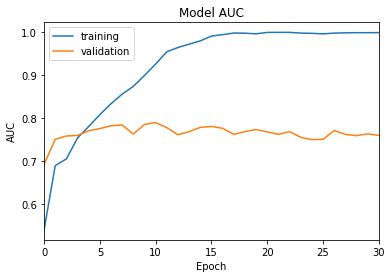

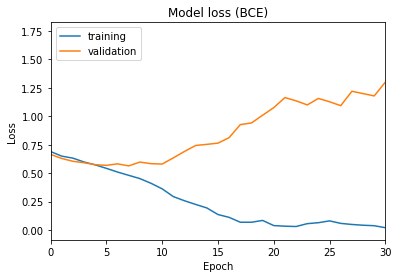

In [ ]:
# summarize history for accuracy
plt.plot(history.history['auc_1'])
plt.plot(history.history['val_auc_1'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.xlim((0,30))
plt.legend(['training', 'validation'], loc='upper left')
plt.savefig('figures/histogram_cnn_lstm_training_auc.png', dpi=300);
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (BCE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim((0,30))
plt.legend(['training', 'validation'], loc='upper left')
plt.savefig('figures/histogram_cnn_lstm_training_loss.png', dpi=300);
plt.show()

In [ ]:
model.load_weights(checkpoint_filepath)

#### Evaluate best model

In [ ]:
model.evaluate(test_generator,
               return_dict=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


35/35 [==============================] - 174s 5s/step - loss: 0.5531 - accuracy: 0.7301 - precision_1: 0.7288 - recall_1: 0.7058 - auc_1: 0.7940


{'accuracy': 0.7301443815231323,
 'auc_1': 0.793964684009552,
 'loss': 0.5530775189399719,
 'precision_1': 0.7288461327552795,
 'recall_1': 0.7057728171348572}

In [ ]:
preds = model.predict(test_generator).flatten()
thresh = 0.5
pred_classes = np.where(preds > thresh, 1, 0)
test_classes = np.concatenate([y for _,y in test_generator], axis=-1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
cf_matrix = confusion_matrix(test_classes, pred_classes)
cf_matrix_norm = confusion_matrix(test_classes, pred_classes, normalize='true')

# # From https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_norm.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_norm, annot=labels, fmt="", cmap='Blues');
plt.title('Confusion matrix')
plt.savefig('figures/histogram_cnn_lstm_confusion.png', dpi=300);

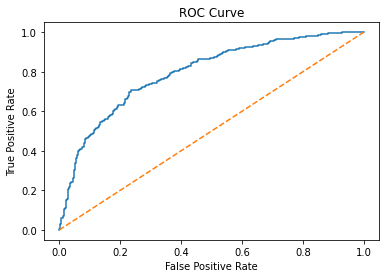

In [ ]:
fpr, tpr, _ = roc_curve(test_classes, preds)

plt.plot(fpr, tpr, label='ROC')
plt.plot([0,1], [0,1], linestyle='dashed')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.savefig('figures/histogram_cnn_lstm_roc_curve.png', dpi=300)